# Analisis De Volumen

1. De que tratan las empresas que se estan consitituyendo? NLP en descripcion de actividades.
2. Hay algun patron geografico? (x ej con https://kepler.gl/)
3. Hay cambios a lo largo del tiempo? Algún peak interesante?
4. Qué características de empresa tienden a pedir cuenta corriente y cuáles no?
5. Cuánto tiempo pasa entre que una empresa se constituye y solicitan una cuenta corriente?
6. Podemos ver alguna red de RUTs? Gente que esta relacionada en varias empresas (quizas con https://www.graphext.com/)


In [1]:
#!pip install awswrangler
#!pip install --upgrade seaborn
#!pip install wordcloud
#!pip install --upgrade pandas
#!pip install unidecode
#!pip install gensim

In [18]:
import boto3

import pandas as pd
import awswrangler as wr
import seaborn as sns
import numpy as np
sns.set_theme()

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,8
rcParams['font.family'] = "roboto"

In [7]:
bucket='legalres-storage-study-json'
prefix = 'processed'
data_location = 's3://{}/{}/'.format(bucket, prefix)

session = boto3.Session(profile_name='legalbot')
boto3.setup_default_session(profile_name='legalbot')
s3 = boto3.client('s3')


In [8]:
df = wr.s3.read_parquet(path=data_location,
                        boto3_session=session)

In [9]:
df.shape

(881320, 7)

In [10]:
df.columns

Index(['rut', 'cve', 'fecha', 'lugar', 'tipo_sociedad', 'objeto', 'firmas'], dtype='object')

In [11]:
df.head()

,rut,cve,fecha,lugar,tipo_sociedad,objeto,firmas
0,76305353-9,AC00DaeUV9O5,2013-10-16,"En PROVIDENCIA, Región METROPOLITANA DE SANTIA...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
1,76313659-0,AC00iMWofV5q,2013-10-28,"En QUILPUE, Región de VALPARAISO, Chile, a 28 ...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
2,76313458-K,AC01CGsqBCMM,2013-10-25,"En COYHAIQUE, Región de AYSEN DEL GRAL. CARLOS...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
3,76313026-6,AC01YjJkTvS3,2013-10-23,"En PUENTE ALTO, Región METROPOLITANA DE SANTIA...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
4,76304233-2,AC1DrSkE1pdl,2013-10-08,"En TEMUCO, Región de LA ARAUCANIA, Chile, a 08...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."


## EDA

### Rut repetidos? 

In [12]:
df['rut'].value_counts().head()

76583346-9    2
77310252-K    2
76304404-1    2
77117628-3    2
76826175-K    2
Name: rut, dtype: Int64

Un ejemplo de rut repetido

In [13]:
df.loc[df['rut'] == df['rut'].value_counts().index[0]]

,rut,cve,fecha,lugar,tipo_sociedad,objeto,firmas
137194,76583346-9,AC8Vdm3ERua9,2016-01-25,"En PROVIDENCIA, Región METROPOLITANA DE SANTIA...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
137493,76583346-9,ACBvqmum11lT,2016-01-20,"En PUERTO NATALES, Región de MAGALLANES Y DE L...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."


### Volumen y fechas

In [40]:
volumen = df.groupby(pd.Grouper(key='fecha', freq='m'))['rut'].count().to_frame()

In [41]:
volumen['MM6'] = volumen['rut'].rolling(6).mean()

In [42]:
print(volumen.index[0])
print(volumen.index[-1])

2013-05-31 00:00:00
2022-06-30 00:00:00


In [43]:
# remove last month with incomplete data
volumen = volumen.loc[volumen.index[0:-1], :]

In [44]:
volumen.index.name = 'mes'

In [45]:
# Create linear regression line
nums = range(len(volumen.index))
volumen['nums'] = nums
X = volumen['nums'].values
y = volumen['rut'].values
m, b = np.polyfit(X, y, 1)
preds = [m*x+b for x in nums]
volumen['regresion'] = preds

del volumen['nums']

In [46]:
sns.set_context('poster')

In [47]:
volumen

,rut,MM6,regresion
mes,,,
2013-05-31,1685,NaN,2385.868891
2013-06-30,2017,NaN,2491.260208
2013-07-31,2317,NaN,2596.651524
2013-08-31,2180,NaN,2702.042841
2013-09-30,1522,NaN,2807.434158
...,...,...,...
2022-01-31,12256,13853.166667,13346.565842
2022-02-28,10799,12886.333333,13451.957159
2022-03-31,14070,12756.500000,13557.348476


[Text(0.5, 1.0, 'Volumen de CONSTITUCIONES en RES creciendo\nMayo 2013 a Mayo 2021')]

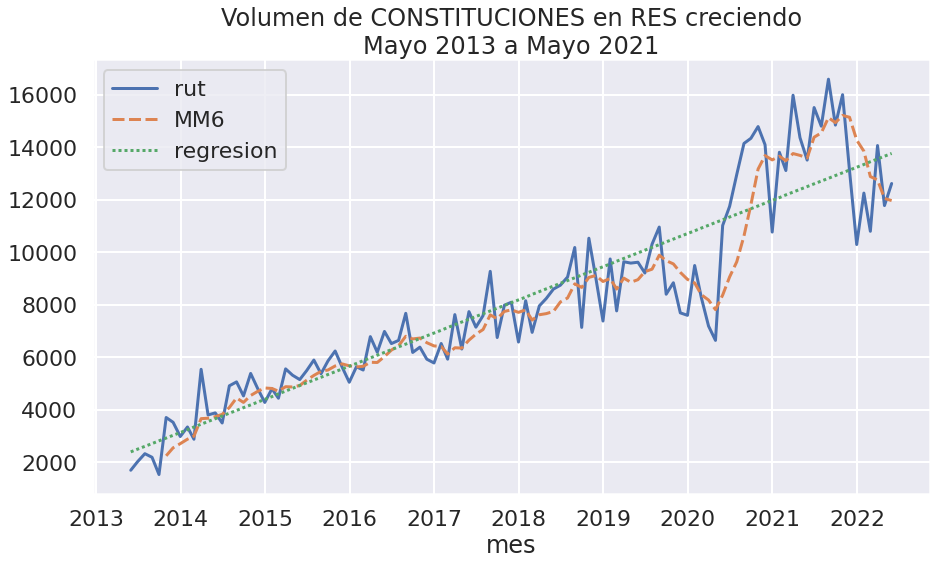

In [48]:
plot = sns.lineplot(data=volumen)
plot.set(title='Volumen de CONSTITUCIONES en RES creciendo\n'
         'Mayo 2013 a Mayo 2021')